# Asset return simulation (Cont model)

## Bogumił Kamiński

We will discuss an implementation of a model of volatility clustering on financial markets that was proposed by Rama Cont.

Assume we have $n$ agents that are trading a single asset. The transactions
take place in discrete time. Each agent has its individual trading threshold
$\theta_i(t)$ that evolves in time; initially $\theta_i(1) = 0$. In each
period news from the company is provided, denote it $\varepsilon_t$. We assume
that $\varepsilon_t$ are IID following standard normal distribution. An
individual agent $i$ wants to buy an asset if the news is good enough,
formally $\varepsilon_t > \theta_i(t)$. Similarly the agent wants to sell an
asset if $\varepsilon_t < -\theta_i(t)$. In other words agents that have high
$\theta_i(t)$ are not very likely to trade, while agents that have it very
close to $0$ trade in almost every period. Also note that if
$\varepsilon_t > 0$ then agent either wants to buy or does nothing, while if
$\varepsilon_t < 0$ then agent either wants to sell or does nothing (the case of
$\varepsilon_t = 0$ is degenerated and we leave it unspecified as it will not affect our model
dynamics).

By $Z_t$ denote the sum of all buy bids minus sum of all sell bids placed by
agents in period $t$. Then we define the return of the asset in that period as
$r_t = Z_t / (n \cdot\lambda)$, where $\lambda$ is a parameter of the model,
that can be interpreted as damping factor of the returns.

Now agents observe $r_t$ and each agent with probability $q$ sets its
$\theta_i(t)$ to be $|r_t|$. Observe that with this mechanism if the returns
$r_t$ are large in absolute values agents become less likely to trade in the
future, while if it is close to $0$ more trades are likely to take place in
next rounds.

We will want to check if the distribution of asset returns $r_t$ produced
by this model exhibits positive excess kurtosis (as would be expected
in financial markets).

In our model we have three parameters $n$ (number of agents), $\lambda$
(scaling factor of the returns), and $q$ (probability to change
$\theta_i(t)$ in one round). A careful reader will note that the model has one
less parameter than the one described in the [original paper](https://link.springer.com/chapter/10.1007/978-3-540-34625-8_10). The reason for
this is explained [here](https://link.springer.com/chapter/10.1007/978-3-319-47253-9_29), and it does not affect our analysis.
Additionally we will need to specify the time, as the number of ticks of the
simulation, during which we will track the simulation of our model.


####  Implemeentation of the simulator

In [1]:
using DataFrames
using Plots
using ProgressMeter
using Random
using StatsBase

In [2]:
function cont_run(time=1000, n=1000, λ=0.05, q=0.1)
    r = zeros(time)
    θ = zeros(n)
    pchange = zeros(n)
    for t = 1:time
        ε = randn()
        if ε > 0
            r[t] =  sum(<(ε), θ) / (λ * n)
        else
            r[t] =  -sum(<(-ε), θ) / (λ * n)
        end
        θ .= ifelse.(rand!(pchange) .< q, abs(r[t]), θ)
    end
    return kurtosis(r)
end

cont_run (generic function with 5 methods)

In [3]:
@time cont_run(),
@time cont_run()

  0.000962 seconds (3 allocations: 23.812 KiB)
  0.013689 seconds (8.30 k allocations: 674.102 KiB, 83.27% compilation time)


(0.8583094304240477, 0.9362581012160249)

#### Testing the simulator

In [4]:
function run_sim(time=1000, n=1000)
    df = DataFrame()
    @showprogress for λ in range(0.01, 0.05, length=51), q in range(0.01, 0.05, length=51)
        push!(df, (λ=λ, q=q, k=cont_run(time, n, λ, q)))
    end
    return df
end

run_sim (generic function with 3 methods)

In [5]:
Random.seed!(1234)

TaskLocalRNG()

In [6]:
df = run_sim()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Row,λ,q,k
,Float64,Float64,Float64
1,0.01,0.01,2.34386
2,0.01,0.0108,4.03204
3,0.01,0.0116,4.45314
4,0.01,0.0124,4.21231
5,0.01,0.0132,4.46345
6,0.01,0.014,3.69509
7,0.01,0.0148,4.01405
8,0.01,0.0156,6.20649
9,0.01,0.0164,4.80494


In [7]:
udf = unstack(df, :λ, :q, :k)

Row,λ,0.01,0.0108,0.0116,0.0124,0.0132,0.014,0.0148,0.0156,0.0164,0.0172,0.018,0.0188,0.0196,0.0204,0.0212,0.022,0.0228,0.0236,0.0244,0.0252,0.026,0.0268,0.0276,0.0284,0.0292,0.03,0.0308,0.0316,0.0324,0.0332,0.034,0.0348,0.0356,0.0364,0.0372,0.038,0.0388,0.0396,0.0404,0.0412,0.042,0.0428,0.0436,0.0444,0.0452,0.046,0.0468,0.0476,0.0484,0.0492,0.05
,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,0.01,2.34386,4.03204,4.45314,4.21231,4.46345,3.69509,4.01405,6.20649,4.80494,4.54297,5.51011,6.92552,5.39171,6.1064,6.08999,6.5968,6.64415,7.56495,7.14356,8.75606,5.76698,7.75904,7.20474,7.83139,5.67526,5.56175,6.24032,6.52369,7.10421,6.29113,8.78249,6.75843,4.8541,6.60786,7.17562,5.32893,6.36762,8.71121,5.84511,7.62082,4.67805,8.21479,4.89354,6.05615,5.84139,7.1082,4.7598,4.68779,6.55109,5.96454,5.61597
2,0.0108,3.88171,3.58639,3.80865,3.50301,5.55701,5.21526,4.89731,5.21151,7.0169,5.91161,4.92188,4.54051,4.63439,6.07061,4.20646,3.772,6.32141,6.89307,5.33883,7.62855,7.0247,8.69333,7.10607,6.51148,6.98679,6.31377,6.43741,6.13163,7.96562,6.16467,6.90875,6.15427,6.74067,6.69707,5.67095,4.35954,6.54234,4.58165,6.41054,5.94576,6.80543,4.74397,5.96921,6.26986,4.6829,5.11077,4.63176,6.07228,4.30448,5.68806,5.49155
3,0.0116,2.66086,4.39181,4.85954,4.13026,5.99363,4.49105,6.65475,5.15225,4.37074,5.50572,4.59664,4.7734,6.11469,6.16791,8.41735,6.08909,5.47723,5.80248,6.18161,5.41131,6.84162,7.93016,6.60344,5.10255,5.58129,5.96236,6.88755,4.46585,5.83696,6.9384,6.50755,6.06421,5.53325,4.69176,6.66186,4.54703,6.89624,5.22793,5.43417,4.93514,6.59922,4.89902,4.91955,5.79692,5.33655,6.0277,5.40704,5.45323,5.26701,4.68649,5.01564
4,0.0124,4.30746,4.01011,4.02381,3.87596,4.33212,5.13445,4.13762,4.61712,5.61107,6.26332,6.349,5.77009,4.84969,5.9364,6.29458,7.32518,6.12077,8.25678,6.39312,5.36668,6.8728,7.28544,6.20944,5.92105,5.58208,6.01852,5.83046,5.3714,5.6405,6.85855,5.00532,7.14804,6.04973,6.46286,6.20513,5.00586,7.72828,5.86191,5.22344,5.10037,5.04985,6.35968,6.52366,5.19321,5.32164,5.43655,4.5937,5.01372,5.39787,5.42026,5.06991
5,0.0132,3.8592,3.77992,3.53459,3.80768,3.8437,5.35517,5.18732,5.08387,5.82375,6.31628,5.78104,5.74845,5.94236,4.21246,6.35592,5.31098,5.79241,5.42778,4.23093,5.97007,5.46913,6.08111,4.77596,4.44119,6.17588,5.27563,6.09768,6.35711,5.82055,5.12655,6.32252,5.54579,6.24194,4.61187,3.37073,6.57127,4.19483,5.14082,4.04704,5.16854,5.31603,5.44621,5.57124,4.7759,5.44197,5.03574,4.87009,5.53295,5.25247,4.60531,3.41617
6,0.014,3.15738,3.75924,3.95904,4.06458,5.20331,4.7214,3.69534,5.82739,5.90521,5.16157,6.4161,5.79,5.13373,5.93688,6.64336,5.22773,4.4824,6.85371,4.98439,6.80596,6.49417,4.74821,5.97515,4.82657,6.34139,7.03575,4.11867,4.94723,5.66746,5.73957,6.71328,5.93973,4.94027,4.44804,5.7674,5.72422,5.47191,6.62124,5.06397,5.12851,4.47699,6.27311,5.89345,4.90033,4.59317,5.59808,4.04743,4.14785,5.23165,5.22765,4.31157
7,0.0148,3.41577,2.93872,3.44623,3.56307,4.43378,4.96696,4.26912,4.54032,3.83414,5.37034,4.93599,4.99073,5.46238,5.2111,4.78404,5.29535,5.3483,4.53028,4.62957,6.62408,5.46676,5.93866,6.2338,5.7695,4.81379,4.3247,5.07541,4.61454,6.45489,6.19322,5.476,6.89074,4.55359,4.83252,5.78499,5.58696,4.05032,5.26049,4.50547,4.87844,4.29564,4.86562,5.91023,5.07594,4.308,4.45261,5.21945,6.09654,4.83464,5.15086,4.59803
8,0.0156,3.5107,3.01393,4.95562,3.77301,4.23787,4.43191,3.9358,3.96241,4.34443,4.77513,6.29685,5.33683,5.27433,6.04462,7.21368,5.72187,4.54221,4.47123,4.93222,4.81046,7.2324,6.21427,4.65468,4.77947,6.20395,4.73228,4.80683,4.96765,5.49294,4.8657,4.52514,4.11286,4.72189,4.78636,4.70635,5.56228,4.66114,4.921

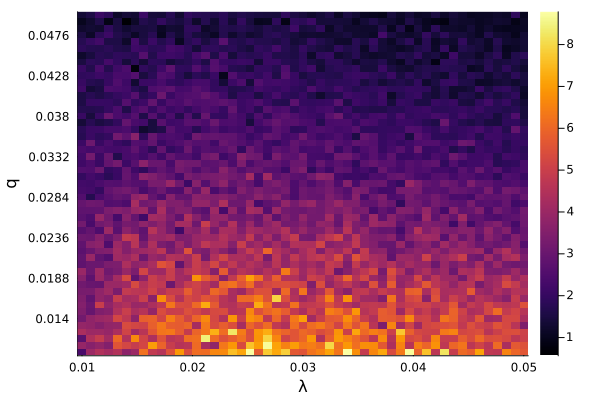

In [8]:
heatmap(udf.λ,
        names(udf, Not(1)),
        Matrix(udf)[:, 2:end];
        xlabel="λ", ylabel="q")

The results look a bit unstable. Let us get 10 observations per pont and average them.

In [9]:
for i in 1:9
    append!(df, run_sim())
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


In [10]:
df

Row,λ,q,k
,Float64,Float64,Float64
1,0.01,0.01,2.34386
2,0.01,0.0108,4.03204
3,0.01,0.0116,4.45314
4,0.01,0.0124,4.21231
5,0.01,0.0132,4.46345
6,0.01,0.014,3.69509
7,0.01,0.0148,4.01405
8,0.01,0.0156,6.20649
9,0.01,0.0164,4.80494


In [11]:
udf = unstack(df, :λ, :q, :k, combine=mean)

Row,λ,0.01,0.0108,0.0116,0.0124,0.0132,0.014,0.0148,0.0156,0.0164,0.0172,0.018,0.0188,0.0196,0.0204,0.0212,0.022,0.0228,0.0236,0.0244,0.0252,0.026,0.0268,0.0276,0.0284,0.0292,0.03,0.0308,0.0316,0.0324,0.0332,0.034,0.0348,0.0356,0.0364,0.0372,0.038,0.0388,0.0396,0.0404,0.0412,0.042,0.0428,0.0436,0.0444,0.0452,0.046,0.0468,0.0476,0.0484,0.0492,0.05
,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,0.01,2.9797,3.87193,4.0311,4.3463,4.74785,4.30382,5.31862,5.60713,5.60927,5.85984,6.14473,5.77684,6.16782,6.22291,6.06258,6.65462,6.06462,6.28245,6.5897,6.90633,6.23521,6.70516,6.27285,6.50283,6.39606,6.08162,6.3115,6.70125,6.19566,6.61924,6.94857,6.97955,6.38375,6.15223,6.41936,6.47622,6.30894,6.86557,5.96877,6.30657,5.97605,6.59307,6.43063,5.96458,5.43354,5.58475,5.6618,5.30681,5.6833,5.74841,5.3828
2,0.0108,3.45657,3.86594,4.12269,4.32874,4.89776,4.95183,5.10676,4.99509,5.7115,5.77439,5.67482,4.97514,6.31956,5.63134,6.46042,5.55041,6.09696,6.51372,6.41992,6.27138,6.43141,7.11556,6.52021,6.52331,6.16845,6.62307,6.85889,6.07499,6.53489,6.94297,6.84591,5.88563,6.23584,6.24954,6.25642,6.25364,5.62471,6.20607,6.61979,5.97151,5.99072,5.86934,5.84229,5.44136,5.90551,5.8174,5.08491,5.43931,5.41407,5.39563,5.31365
3,0.0116,3.18071,3.94942,4.1352,4.66784,4.79177,5.10092,5.30578,5.3546,4.78563,5.68534,6.17765,6.03453,6.25659,6.16672,6.4528,5.65263,6.22941,6.6217,6.234,6.70757,6.28216,6.81805,6.60323,6.00621,6.67794,6.32029,6.39068,6.28446,6.11212,6.64521,6.35913,5.94704,6.12534,6.28071,5.72371,5.40638,6.4736,5.86758,6.06044,5.59694,5.63386,5.93545,6.09279,5.74354,5.45214,5.40212,5.3608,5.56692,5.53653,5.34241,5.33638
4,0.0124,3.44375,3.27616,3.78862,3.91854,4.49399,4.81245,5.27884,5.12477,5.36389,6.02068,5.82441,5.67222,5.95021,5.73695,6.10952,5.57039,5.83779,6.15904,6.51358,6.12811,6.2953,6.91062,6.13053,6.27669,6.37334,6.36026,6.96622,5.68357,6.00268,6.06815,5.77159,6.09205,6.10623,6.05557,5.97291,5.66091,5.86088,5.65918,5.71104,5.42708,5.5094,5.66659,5.94656,5.65729,4.98421,5.72044,4.8077,4.99008,4.95312,5.22739,5.35463
5,0.0132,3.25134,3.82292,4.00077,4.29391,4.77059,4.80669,5.47181,5.46387,5.06828,5.91627,5.63498,6.05162,5.73589,5.58494,5.84838,5.48585,6.31723,5.62182,5.71537,6.09956,5.80191,6.26349,6.10579,6.27903,6.00948,6.15811,5.27581,6.35367,6.01426,6.10895,5.63113,5.68729,5.33292,5.27809,5.34035,5.89905,5.66351,5.20131,5.36758,5.57782,5.62441,5.3055,5.5206,5.27041,4.99877,5.24758,5.06668,5.19173,5.00152,4.90381,4.65127
6,0.014,3.40492,3.65794,3.88975,4.48554,4.53061,4.22438,4.29653,5.28038,5.27463,4.99603,5.78004,5.31106,5.47428,5.49761,5.46101,5.42565,5.10022,5.94078,6.08049,5.94737,5.69224,5.63985,5.89968,5.5534,5.7263,5.929,5.31602,5.67414,5.55484,5.94769,5.65316,5.82361,5.68209,4.93303,5.36239,6.09035,5.15698,5.47068,5.21291,5.18452,4.85893,5.5216,4.86528,5.17637,5.07136,4.84657,4.77468,4.50823,4.79402,4.69835,4.61427
7,0.0148,2.92604,3.74051,3.63575,3.90058,4.13731,4.43354,4.7547,4.68956,5.21448,5.20922,5.26592,5.01122,5.67323,5.59987,5.26978,5.53354,6.16725,5.77194,5.27819,6.18638,5.90172,5.93207,5.4834,5.88237,5.49504,5.33636,5.74378,5.41091,5.24585,5.46642,5.48837,5.81731,4.97003,5.12232,4.92612,5.30671,5.34995,5.24264,5.23176,4.72755,4.87277,4.87475,4.80889,4.8029,5.00442,4.64599,4.96373,4.96563,4.67609,4.973,4.68128
8,0.0156,3.22316,3.40991,3.93754,3.92779,4.10179,4.38375,4.52772,4.5943,4.85453,4.97745,5.4119,4.97335,5.18504,5.41455,5.506,5.18955,5.03339,5.10187,5.81796,5.37538,5.90256,5.50746,5.14123,5.3659,5.5056,5.06203,5.1569,4.83724,5.11242,5.28891,5.24186,5.09648,5.69825,5.35695,4.67953,5.35034,4.94785,5.

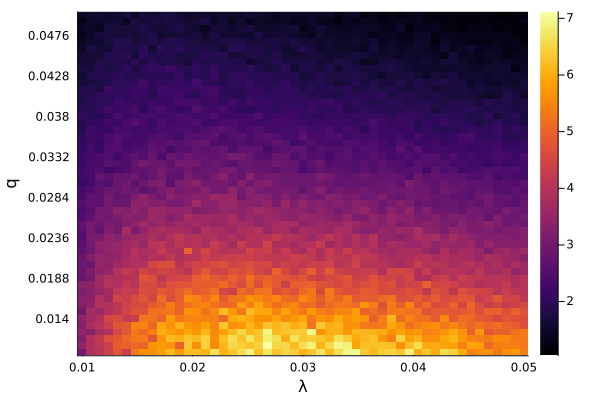

In [12]:
heatmap(udf.λ,
        names(udf, Not(1)),
        Matrix(udf)[:, 2:end];
        xlabel="λ", ylabel="q")